In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *

import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
#from fastai.text import *
from fastai.lm_rnn import *

import dill as pickle

/home/zero/anaconda/envs/fastai-cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/zero/anaconda/envs/fastai-cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/zero/anaconda/envs/fastai-cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/zero/anaconda/envs/fastai-cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/zero/anaconda/envs/fastai-cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  re

## Language modeling

### Data

In [3]:
reviews_label = pd.read_pickle('/media/zero/Data/Dropbox/metadata/foody review/foody review.pkl')

In [4]:
reviews = reviews_label[['review_content']]

In [5]:
PATH = '/home/zero/fastai/courses/dl1/data/foody/'

In [6]:
bs=64; bptt=10

In [7]:
TEXT = data.Field(lower=True, tokenize=spacy_tok)

In [9]:
??LanguageModelData

In [8]:
md = LanguageModelData.from_dataframes(PATH, TEXT, col = 'review_content', 
                                       train_df = reviews[:1000] , val_df=reviews[1000:1500], test_df=reviews[1000:1500],
                                       bs=bs, bptt=bptt, min_freq=10)

AttributeError: type object 'LanguageModelData' has no attribute 'from_dataframes'

After building our `ModelData` object, it automatically fills the `TEXT` object with a very important attribute: `TEXT.vocab`. This is a *vocabulary*, which stores which words (or *tokens*) have been seen in the text, and how each word will be mapped to a unique integer id. We'll need to use this information again later, so we save it.

*(Technical note: python's standard `Pickle` library can't handle this correctly, so at the top of this notebook we used the `dill` library instead and imported it as `pickle`)*.

In [16]:
pickle.dump(TEXT, open(f'{PATH}models/TEXT.pkl','wb'))

Here are the: # batches; # unique tokens in the vocab; # tokens in the training set; # sentences

In [17]:
len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(178, 1141, 1, 114596)

This is the start of the mapping from integer IDs to unique tokens.

In [18]:
# 'itos': 'int-to-string'
TEXT.vocab.itos[:12]

['<unk>',
 '<pad>',
 ',',
 '.',
 'mình',
 'ăn',
 '\n',
 'có',
 'quán',
 'là',
 'không',
 'thì']

In [20]:
# 'stoi': 'string to int'
TEXT.vocab.stoi['ngon']

14

Note that in a `LanguageModelData` object there is only one item in each dataset: all the words of the text joined together.

In [21]:
md.trn_ds[0].text[:12]

['quán',
 'steak',
 'hiếm',
 'hoi',
 'mà',
 'mình',
 'cực',
 'kì',
 'ưng',
 'ý',
 'từ',
 'lâu']

torchtext will handle turning this words into integer IDs for us automatically.

In [22]:
TEXT.numericalize([md.trn_ds[0].text[:12]])

Variable containing:
    8
    0
    0
    0
   20
    4
  118
  402
  525
  187
  125
  151
[torch.LongTensor of size 12x1]

Our `LanguageModelData` object will create batches with 64 columns (that's our batch size), and varying sequence lengths of around 80 tokens (that's our `bptt` parameter - *backprop through time*).

Each batch also contains the exact same data as labels, but one word later in the text - since we're trying to always predict the next word. The labels are flattened into a 1d array.

In [24]:
%debug next(iter(md.trn_dl))

NOTE: Enter 'c' at the ipdb>  prompt to continue execution.
> <string>(1)<module>()

ipdb> s
--Call--
> /home/zero/fastai/courses/dl1/fastai/nlp.py(128)__iter__()
    126         self.n = len(self.data)
    127 
--> 128     def __iter__(self):
    129         self.i,self.iter = 0,0
    130         return self

ipdb> ll
--> 128     def __iter__(self):
    129         self.i,self.iter = 0,0
    130         return self
    131 

ipdb> s
> /home/zero/fastai/courses/dl1/fastai/nlp.py(129)__iter__()
    127 
    128     def __iter__(self):
--> 129         self.i,self.iter = 0,0
    130         return self
    131 

ipdb> 
> /home/zero/fastai/courses/dl1/fastai/nlp.py(130)__iter__()
    128     def __iter__(self):
    129         self.i,self.iter = 0,0
--> 130         return self
    131 
    132     def __len__(self): return self.n // self.bptt - 1

ipdb> s
--Return--
<fastai.nlp.L...x7f7254d24898>
> /home/zero/fastai/courses/dl1/fastai/nlp.py(130)__iter__()
    128     def __iter__(self):
 

### Train

We have a number of parameters to set - we'll learn more about these later, but you should find these values suitable for many problems.

In [25]:
em_sz = 20  # size of each embedding vector
nh = 50     # number of hidden activations per layer
nl = 2       # number of layers

Researchers have found that large amounts of *momentum* (which we'll learn about later) don't work well with these kinds of *RNN* models, so we create a version of the *Adam* optimizer with less momentum than it's default of `0.9`.

In [26]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

fastai uses a variant of the state of the art [AWD LSTM Language Model](https://arxiv.org/abs/1708.02182) developed by Stephen Merity. A key feature of this model is that it provides excellent regularization through [Dropout](https://en.wikipedia.org/wiki/Convolutional_neural_network#Dropout). There is no simple way known (yet!) to find the best values of the dropout parameters below - you just have to experiment...

However, the other parameters (`alpha`, `beta`, and `clip`) shouldn't generally need tuning.

In [27]:
%debug md.get_model(opt_fn, em_sz, nh, nl, dropouti=0.05, dropout=0.05, wdrop=0.1, dropoute=0.02, dropouth=0.05)

NOTE: Enter 'c' at the ipdb>  prompt to continue execution.
> <string>(1)<module>()

ipdb> s
> <string>(2)<module>()

ipdb> s
> <string>(3)<module>()

ipdb> s
> <string>(4)<module>()

ipdb> s
> <string>(5)<module>()

ipdb> s
> <string>(6)<module>()

ipdb> ll
*** could not get source code
ipdb> s
> <string>(7)<module>()

ipdb> s
> <string>(8)<module>()

ipdb> s
> <string>(9)<module>()

ipdb> s
--Call--
> /home/zero/fastai/courses/dl1/fastai/nlp.py(256)get_model()
    254                                                   for ds in (self.trn_ds, self.val_ds, self.test_ds) ]
    255 
--> 256     def get_model(self, opt_fn, emb_sz, n_hid, n_layers, **kwargs):
    257         """ Method returns a RNN_Learner object, that wraps an instance of the RNN_Encoder module.
    258 

ipdb> ll
--> 256     def get_model(self, opt_fn, emb_sz, n_hid, n_layers, **kwargs):
    257         """ Method returns a RNN_Learner object, that wraps an instance of the RNN_Encoder module.
    258 
    259         Arg

ipdb> s
> /home/zero/fastai/courses/dl1/fastai/lm_rnn.py(220)get_language_model()
    218 
    219     rnn_enc = RNN_Encoder(n_tok, emb_sz, nhid=nhid, nlayers=nlayers, pad_token=pad_token,
--> 220                  dropouth=dropouth, dropouti=dropouti, dropoute=dropoute, wdrop=wdrop)
    221     enc = rnn_enc.encoder if tie_weights else None
    222     return SequentialRNN(rnn_enc, LinearDecoder(n_tok, emb_sz, dropout, tie_encoder=enc))

ipdb> s
--Call--
> /home/zero/fastai/courses/dl1/fastai/lm_rnn.py(37)__init__()
     35     initrange=0.1
     36 
---> 37     def __init__(self, ntoken, emb_sz, nhid, nlayers, pad_token, bidir=False,
     38                  dropouth=0.3, dropouti=0.65, dropoute=0.1, wdrop=0.5):
     39         """ Default constructor for the RNN_Encoder class

ipdb> ;;
> /home/zero/fastai/courses/dl1/fastai/lm_rnn.py(57)__init__()
     55           """
     56 
---> 57         super().__init__()
     58         self.ndir = 2 if bidir else 1
     59         self.bs = 

ipdb> s
> /home/zero/anaconda/envs/fastai-cpu/lib/python3.6/site-packages/torch/nn/modules/module.py(401)__setattr__()
    399 
    400     def __setattr__(self, name, value):
--> 401         def remove_from(*dicts):
    402             for d in dicts:
    403                 if name in d:

ipdb> s
> /home/zero/anaconda/envs/fastai-cpu/lib/python3.6/site-packages/torch/nn/modules/module.py(406)__setattr__()
    404                     del d[name]
    405 
--> 406         params = self.__dict__.get('_parameters')
    407         if isinstance(value, Parameter):
    408             if params is None:

ipdb> s
> /home/zero/anaconda/envs/fastai-cpu/lib/python3.6/site-packages/torch/nn/modules/module.py(407)__setattr__()
    405 
    406         params = self.__dict__.get('_parameters')
--> 407         if isinstance(value, Parameter):
    408             if params is None:
    409                 raise AttributeError(

ipdb> s
> /home/zero/anaconda/envs/fastai-cpu/lib/python3.6/site-package

ipdb> u
> /home/zero/anaconda/envs/fastai-cpu/lib/python3.6/site-packages/torch/nn/modules/module.py(51)__init__()
     49 
     50     def __init__(self):
---> 51         self._backend = thnn_backend
     52         self._parameters = OrderedDict()
     53         self._buffers = OrderedDict()

ipdb> n
> /home/zero/anaconda/envs/fastai-cpu/lib/python3.6/site-packages/torch/nn/modules/module.py(52)__init__()
     50     def __init__(self):
     51         self._backend = thnn_backend
---> 52         self._parameters = OrderedDict()
     53         self._buffers = OrderedDict()
     54         self._backward_hooks = OrderedDict()

ipdb> n
> /home/zero/anaconda/envs/fastai-cpu/lib/python3.6/site-packages/torch/nn/modules/module.py(53)__init__()
     51         self._backend = thnn_backend
     52         self._parameters = OrderedDict()
---> 53         self._buffers = OrderedDict()
     54         self._backward_hooks = OrderedDict()
     55         self._forward_hooks = OrderedDict()

i

ipdb> n
> /home/zero/fastai/courses/dl1/fastai/lm_rnn.py(62)__init__()
     60         self.encoder = nn.Embedding(ntoken, emb_sz, padding_idx=pad_token)
     61         self.encoder_with_dropout = EmbeddingDropout(self.encoder)
---> 62         self.rnns = [nn.LSTM(emb_sz if l == 0 else nhid, (nhid if l != nlayers - 1 else emb_sz)//self.ndir,
     63              1, bidirectional=bidir, dropout=dropouth) for l in range(nlayers)]
     64         if wdrop: self.rnns = [WeightDrop(rnn, wdrop) for rnn in self.rnns]

ipdb> n
> /home/zero/fastai/courses/dl1/fastai/lm_rnn.py(63)__init__()
     61         self.encoder_with_dropout = EmbeddingDropout(self.encoder)
     62         self.rnns = [nn.LSTM(emb_sz if l == 0 else nhid, (nhid if l != nlayers - 1 else emb_sz)//self.ndir,
---> 63              1, bidirectional=bidir, dropout=dropouth) for l in range(nlayers)]
     64         if wdrop: self.rnns = [WeightDrop(rnn, wdrop) for rnn in self.rnns]
     65         self.rnns = torch.nn.ModuleList(

ipdb> n
--Return--
None
> /home/zero/fastai/courses/dl1/fastai/lm_rnn.py(70)__init__()
     68         self.emb_sz,self.nhid,self.nlayers,self.dropoute = emb_sz,nhid,nlayers,dropoute
     69         self.dropouti = LockedDropout(dropouti)
---> 70         self.dropouths = nn.ModuleList([LockedDropout(dropouth) for l in range(nlayers)])
     71 
     72     def forward(self, input):

ipdb> n
> /home/zero/fastai/courses/dl1/fastai/lm_rnn.py(221)get_language_model()
    219     rnn_enc = RNN_Encoder(n_tok, emb_sz, nhid=nhid, nlayers=nlayers, pad_token=pad_token,
    220                  dropouth=dropouth, dropouti=dropouti, dropoute=dropoute, wdrop=wdrop)
--> 221     enc = rnn_enc.encoder if tie_weights else None
    222     return SequentialRNN(rnn_enc, LinearDecoder(n_tok, emb_sz, dropout, tie_encoder=enc))
    223 

ipdb> n
> /home/zero/fastai/courses/dl1/fastai/lm_rnn.py(222)get_language_model()
    220                  dropouth=dropouth, dropouti=dropouti, dropoute=dropoute, wdrop=wdr

ipdb> u
> /home/zero/fastai/courses/dl1/fastai/lm_rnn.py(222)get_language_model()
    220                  dropouth=dropouth, dropouti=dropouti, dropoute=dropoute, wdrop=wdrop)
    221     enc = rnn_enc.encoder if tie_weights else None
--> 222     return SequentialRNN(rnn_enc, LinearDecoder(n_tok, emb_sz, dropout, tie_encoder=enc))
    223 
    224 

ipdb> n
--Return--
SequentialRNN...t(
    )
  )
)
> /home/zero/fastai/courses/dl1/fastai/lm_rnn.py(222)get_language_model()
    220                  dropouth=dropouth, dropouti=dropouti, dropoute=dropoute, wdrop=wdrop)
    221     enc = rnn_enc.encoder if tie_weights else None
--> 222     return SequentialRNN(rnn_enc, LinearDecoder(n_tok, emb_sz, dropout, tie_encoder=enc))
    223 
    224 

ipdb> n
> /home/zero/fastai/courses/dl1/fastai/nlp.py(271)get_model()
    269         """
    270         m = get_language_model(self.nt, emb_sz, n_hid, n_layers, self.pad_idx, **kwargs)
--> 271         model = SingleModel(to_gpu(m))
    272         re

ipdb> n
> /home/zero/fastai/courses/dl1/fastai/nlp.py(272)get_model()
    270         m = get_language_model(self.nt, emb_sz, n_hid, n_layers, self.pad_idx, **kwargs)
    271         model = SingleModel(to_gpu(m))
--> 272         return RNN_Learner(self, model, opt_fn=opt_fn)
    273 
    274     @classmethod

ipdb> s
--Call--
> /home/zero/fastai/courses/dl1/fastai/nlp.py(156)__init__()
    154 
    155 class RNN_Learner(Learner):
--> 156     def __init__(self, data, models, **kwargs):
    157         super().__init__(data, models, **kwargs)
    158         self.crit = F.cross_entropy

ipdb> ll
--> 156     def __init__(self, data, models, **kwargs):
    157         super().__init__(data, models, **kwargs)
    158         self.crit = F.cross_entropy
    159 

ipdb> n
> /home/zero/fastai/courses/dl1/fastai/nlp.py(157)__init__()
    155 class RNN_Learner(Learner):
    156     def __init__(self, data, models, **kwargs):
--> 157         super().__init__(data, models, **kwargs)
    158      

In [28]:
learner = md.get_model(opt_fn, em_sz, nh, nl, dropouti=0.05, dropout=0.05, wdrop=0.1, dropoute=0.02, dropouth=0.05)
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip=0.3

As you can see below, I gradually tuned the language model in a few stages. I possibly could have trained it further (it wasn't yet overfitting), but I didn't have time to experiment more. Maybe you can see if you can train it to a better accuracy! (I used `lr_find` to find a good learning rate, but didn't save the output in this notebook. Feel free to try running it yourself now.)

In [31]:
learner.fit(3e-3, 1, wds=1e-6) #,, cycle_len=1, cycle_mult=2 

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      5.768159   5.626659  



[5.626659]

In [42]:
learner.save_encoder('adam1_enc')

In [20]:
learner.load_encoder('adam1_enc')

In [22]:
learner.load_cycle('adam3_10',2)

In [23]:
learner.fit(3e-3, 1, wds=1e-6, cycle_len=10)

Widget Javascript not detected.  It may not be installed or enabled properly.


[ 0.      4.3926  4.2917]                                       
[ 1.       4.37693  4.28255]                                  
[ 2.       4.37998  4.27243]                                  
[ 3.       4.34284  4.24789]                                  
[ 4.      4.3287  4.2317]                                     
[ 5.       4.28881  4.20722]                                  
[ 6.       4.24637  4.18926]                                  
[ 7.       4.23797  4.17644]                                  
[ 8.       4.20074  4.16989]                                  
[ 9.       4.18873  4.16866]                                  



In [24]:
learner.save_encoder('adam3_10_enc')

In the sentiment analysis section, we'll just need half of the language model - the *encoder*, so we save that part.

In [25]:
learner.save_encoder('adam3_20_enc')

In [26]:
learner.load_encoder('adam3_20_enc')

Language modeling accuracy is generally measured using the metric *perplexity*, which is simply `exp()` of the loss function we used.

In [27]:
math.exp(4.165)

64.3926824434624

In [121]:
pickle.dump(TEXT, open(f'{PATH}models/TEXT.pkl','wb'))

PicklingError: Can't pickle <class 'torchtext.data.field.Field'>: it's not the same object as torchtext.data.field.Field

### Test

We can play around with our language model a bit to check it seems to be working OK. First, let's create a short bit of text to 'prime' a set of predictions. We'll use our torchtext field to numericalize it so we can feed it to our language model.

We haven't yet added methods to make it easy to test a language model, so we'll need to manually go through the steps.

In [174]:
# Set batch size to 1
m[0].bs=1
# Turn off dropout
m.eval()
# Reset hidden state
m.reset()
# Get predictions from model
res,*_ = m(t)
# Put the batch size back to what it was
m[0].bs=bs

Let's see what the top 10 predictions were for the next word after our short text:

In [125]:
nexts = torch.topk(res[-1], 10)[1]
[TEXT.vocab.itos[o] for o in to_np(nexts)]

['.', ',', '\n', '<eos>', '<unk>', 'luôn', 'nhưng', 'mà', 'nên', 'nha']

...and let's see if our model can generate a bit more text all by itself!

In [145]:
res[-1].topk(2)

(Variable containing:
  7.5100
  6.7214
 [torch.FloatTensor of size 2], Variable containing:
    2
  153
 [torch.LongTensor of size 2])

In [151]:
n = n[1] if n.data[0]==0 else n[0] #if is unknow then choose the second

In [213]:
ida = 102

In [214]:
TEXT.vocab.itos[ida]

'nhất'

In [215]:
a= m(V(ida).unsqueeze(0))[0][-1].topk(2)[1]

In [216]:
a = a[1] if a.data[0]==0 else a[0]

In [217]:
TEXT.vocab.itos[a.data[0]]

'.'

In [82]:
m=learner.model
ss="""quán steak hiếm hoi mà mình cực kì ưng ý từ lâu lắm rồi mới có dịp đi ăn""" # 
s = [spacy_tok(ss)]
t=TEXT.numericalize(s)
' '.join(s[0])

'quán steak hiếm hoi mà mình cực kì ưng ý từ lâu lắm rồi mới có dịp đi ăn'

In [83]:
# Set batch size to 1
m[0].bs=1
# Turn off dropout
m.eval()
# Reset hidden state
m.reset()

In [86]:
%debug m(t)

NOTE: Enter 'c' at the ipdb>  prompt to continue execution.
None
> <string>(1)<module>()

ipdb> s
--Call--
> /home/zero/anaconda/envs/fastai-cpu/lib/python3.6/site-packages/torch/nn/modules/module.py(351)__call__()
    349         return result
    350 
--> 351     def __call__(self, *input, **kwargs):
    352         for hook in self._forward_pre_hooks.values():
    353             hook(self, input)

ipdb> s
> /home/zero/anaconda/envs/fastai-cpu/lib/python3.6/site-packages/torch/nn/modules/module.py(352)__call__()
    350 
    351     def __call__(self, *input, **kwargs):
--> 352         for hook in self._forward_pre_hooks.values():
    353             hook(self, input)
    354         if torch.jit._tracing:

ipdb> s
> /home/zero/anaconda/envs/fastai-cpu/lib/python3.6/site-packages/torch/nn/modules/module.py(354)__call__()
    352         for hook in self._forward_pre_hooks.values():
    353             hook(self, input)
--> 354         if torch.jit._tracing:
    355             resul

ipdb> ll
---> 65     def forward(self, input):
     66         for module in self._modules.values():
     67             input = module(input)
     68         return input
     69 

ipdb> s
> /home/zero/anaconda/envs/fastai-cpu/lib/python3.6/site-packages/torch/nn/modules/container.py(66)forward()
     64 
     65     def forward(self, input):
---> 66         for module in self._modules.values():
     67             input = module(input)
     68         return input

ipdb> s
> /home/zero/anaconda/envs/fastai-cpu/lib/python3.6/site-packages/torch/nn/modules/container.py(67)forward()
     65     def forward(self, input):
     66         for module in self._modules.values():
---> 67             input = module(input)
     68         return input
     69 

ipdb> s
--Call--
> /home/zero/anaconda/envs/fastai-cpu/lib/python3.6/site-packages/torch/nn/modules/module.py(351)__call__()
    349         return result
    350 
--> 351     def __call__(self, *input, **kwargs):
    352         for hook

ipdb> s
> /home/zero/anaconda/envs/fastai-cpu/lib/python3.6/site-packages/torch/nn/modules/module.py(357)__call__()
    355             result = self._slow_forward(*input, **kwargs)
    356         else:
--> 357             result = self.forward(*input, **kwargs)
    358         for hook in self._forward_hooks.values():
    359             hook_result = hook(self, input, result)

ipdb> s
--Call--
> /home/zero/fastai/courses/dl1/fastai/lm_rnn.py(72)forward()
     70         self.dropouths = nn.ModuleList([LockedDropout(dropouth) for l in range(nlayers)])
     71 
---> 72     def forward(self, input):
     73         """ Invoked during the forward propagation of the RNN_Encoder module.
     74         Args:

ipdb> ll
---> 72     def forward(self, input):
     73         """ Invoked during the forward propagation of the RNN_Encoder module.
     74         Args:
     75             input (Tensor): input of shape (batch_size x sentence length)
     76 
     77         Returns:
     78      

ipdb> n
> /home/zero/fastai/courses/dl1/fastai/lm_rnn.py(87)forward()
     85 
     86         emb = self.encoder_with_dropout(input, dropout=self.dropoute if self.training else 0)
---> 87         emb = self.dropouti(emb)
     88 
     89         raw_output = emb

ipdb> n
> /home/zero/fastai/courses/dl1/fastai/lm_rnn.py(89)forward()
     87         emb = self.dropouti(emb)
     88 
---> 89         raw_output = emb
     90         new_hidden,raw_outputs,outputs = [],[],[]
     91         for l, (rnn,drop) in enumerate(zip(self.rnns, self.dropouths)):

ipdb> emb.size()
torch.Size([19, 1, 20])
ipdb> n
> /home/zero/fastai/courses/dl1/fastai/lm_rnn.py(90)forward()
     88 
     89         raw_output = emb
---> 90         new_hidden,raw_outputs,outputs = [],[],[]
     91         for l, (rnn,drop) in enumerate(zip(self.rnns, self.dropouths)):
     92             current_input = raw_output

ipdb> ll
     72     def forward(self, input):
     73         """ Invoked during the forward propagatio

ipdb> u
> /home/zero/fastai/courses/dl1/fastai/lm_rnn.py(91)forward()
     89         raw_output = emb
     90         new_hidden,raw_outputs,outputs = [],[],[]
---> 91         for l, (rnn,drop) in enumerate(zip(self.rnns, self.dropouths)):
     92             current_input = raw_output
     93             with warnings.catch_warnings():

ipdb> n
> /home/zero/fastai/courses/dl1/fastai/lm_rnn.py(92)forward()
     90         new_hidden,raw_outputs,outputs = [],[],[]
     91         for l, (rnn,drop) in enumerate(zip(self.rnns, self.dropouths)):
---> 92             current_input = raw_output
     93             with warnings.catch_warnings():
     94                 warnings.simplefilter("ignore")

ipdb> raw_output.size()
torch.Size([19, 1, 20])
ipdb> n
> /home/zero/fastai/courses/dl1/fastai/lm_rnn.py(93)forward()
     91         for l, (rnn,drop) in enumerate(zip(self.rnns, self.dropouths)):
     92             current_input = raw_output
---> 93             with warnings.catch_warnings()

ipdb> current_input.size()
torch.Size([19, 1, 20])
ipdb> n
> /home/zero/fastai/courses/dl1/fastai/lm_rnn.py(94)forward()
     92             current_input = raw_output
     93             with warnings.catch_warnings():
---> 94                 warnings.simplefilter("ignore")
     95                 raw_output, new_h = rnn(raw_output, self.hidden[l])
     96             new_hidden.append(new_h)

ipdb> n
> /home/zero/fastai/courses/dl1/fastai/lm_rnn.py(95)forward()
     93             with warnings.catch_warnings():
     94                 warnings.simplefilter("ignore")
---> 95                 raw_output, new_h = rnn(raw_output, self.hidden[l])
     96             new_hidden.append(new_h)
     97             raw_outputs.append(raw_output)

ipdb> s
--Call--
> /home/zero/anaconda/envs/fastai-cpu/lib/python3.6/site-packages/torch/nn/modules/module.py(351)__call__()
    349         return result
    350 
--> 351     def __call__(self, *input, **kwargs):
    352         for hook in self._for

ipdb> s
--Call--
> /home/zero/anaconda/envs/fastai-cpu/lib/python3.6/site-packages/torch/nn/modules/module.py(384)__getattr__()
    382             self._forward_pre_hooks = OrderedDict()
    383 
--> 384     def __getattr__(self, name):
    385         if '_parameters' in self.__dict__:
    386             _parameters = self.__dict__['_parameters']

ipdb> ll
--> 384     def __getattr__(self, name):
    385         if '_parameters' in self.__dict__:
    386             _parameters = self.__dict__['_parameters']
    387             if name in _parameters:
    388                 return _parameters[name]
    389         if '_buffers' in self.__dict__:
    390             _buffers = self.__dict__['_buffers']
    391             if name in _buffers:
    392                 return _buffers[name]
    393         if '_modules' in self.__dict__:
    394             modules = self.__dict__['_modules']
    395             if name in modules:
    396                 return modules[name]
    397  

ipdb> u
> /home/zero/fastai/courses/dl1/fastai/lm_rnn.py(95)forward()
     93             with warnings.catch_warnings():
     94                 warnings.simplefilter("ignore")
---> 95                 raw_output, new_h = rnn(raw_output, self.hidden[l])
     96             new_hidden.append(new_h)
     97             raw_outputs.append(raw_output)

ipdb> raw_output.size()
torch.Size([19, 1, 20])
ipdb> ll
     72     def forward(self, input):
     73         """ Invoked during the forward propagation of the RNN_Encoder module.
     74         Args:
     75             input (Tensor): input of shape (batch_size x sentence length)
     76 
     77         Returns:
     78             raw_outputs (tuple(list (Tensor), list(Tensor)): list of tensors evaluated from each RNN layer without using
     79             dropouth, list of tensors evaluated from each RNN layer using dropouth,
     80         """
     81         sl,bs = input.size()
     82         if bs!=self.bs:
     83             

ipdb> n
--Return--
(Variable cont...size 19x1x50]
, (Variable cont... size 1x1x50]
, Variable cont... size 1x1x50]
))
> /home/zero/anaconda/envs/fastai-cpu/lib/python3.6/site-packages/torch/nn/modules/module.py(377)__call__()
    375                     functools.update_wrapper(wrapper, hook)
    376                     grad_fn.register_hook(wrapper)
--> 377         return result
    378 
    379     def __setstate__(self, state):

ipdb> n
--Call--
> /home/zero/anaconda/envs/fastai-cpu/lib/python3.6/warnings.py(468)__exit__()
    466             return None
    467 
--> 468     def __exit__(self, *exc_info):
    469         if not self._entered:
    470             raise RuntimeError("Cannot exit %r without entering first" % self)

ipdb> n
> /home/zero/anaconda/envs/fastai-cpu/lib/python3.6/warnings.py(469)__exit__()
    467 
    468     def __exit__(self, *exc_info):
--> 469         if not self._entered:
    470             raise RuntimeError("Cannot exit %r without entering first" % 

ipdb> len(new_hidden)
1
ipdb> new_hidden
[(Variable containing:
(0 ,.,.) = 

Columns 0 to 8 
   0.0442 -0.0321  0.0275  0.0765  0.0259 -0.0851  0.0561  0.0562 -0.0490

Columns 9 to 17 
   0.0796  0.1238 -0.0084  0.0817  0.0627  0.0081  0.0837  0.0294 -0.0774

Columns 18 to 26 
  -0.0091  0.1209 -0.1500  0.0010  0.0535  0.1974  0.0960 -0.0031  0.1180

Columns 27 to 35 
  -0.0166  0.1620 -0.0534  0.0760 -0.0001  0.0030 -0.0915  0.1087  0.0415

Columns 36 to 44 
   0.0417 -0.1289 -0.2170 -0.0240  0.0730 -0.0698 -0.1602 -0.1231 -0.0672

Columns 45 to 49 
  -0.0341  0.1297 -0.0771 -0.0006 -0.0106
[torch.FloatTensor of size 1x1x50]
, Variable containing:
(0 ,.,.) = 

Columns 0 to 8 
   0.0981 -0.1048  0.1103  0.1592  0.0981 -0.1869  0.0825  0.1477 -0.1041

Columns 9 to 17 
   0.1242  0.3674 -0.0313  0.1732  0.1677  0.0232  0.2449  0.1831 -0.1468

Columns 18 to 26 
  -0.0158  0.2473 -0.2689  0.0024  0.1316  0.4117  0.2161 -0.0075  0.2389

Columns 27 to 35 
  -0.0482  0.2401 -0.1951  0.2428 -0

ipdb> n
> /home/zero/fastai/courses/dl1/fastai/lm_rnn.py(92)forward()
     90         new_hidden,raw_outputs,outputs = [],[],[]
     91         for l, (rnn,drop) in enumerate(zip(self.rnns, self.dropouths)):
---> 92             current_input = raw_output
     93             with warnings.catch_warnings():
     94                 warnings.simplefilter("ignore")

ipdb> n
> /home/zero/fastai/courses/dl1/fastai/lm_rnn.py(93)forward()
     91         for l, (rnn,drop) in enumerate(zip(self.rnns, self.dropouths)):
     92             current_input = raw_output
---> 93             with warnings.catch_warnings():
     94                 warnings.simplefilter("ignore")
     95                 raw_output, new_h = rnn(raw_output, self.hidden[l])

ipdb> n
> /home/zero/fastai/courses/dl1/fastai/lm_rnn.py(94)forward()
     92             current_input = raw_output
     93             with warnings.catch_warnings():
---> 94                 warnings.simplefilter("ignore")
     95                 raw_o

ipdb> n
> /home/zero/fastai/courses/dl1/fastai/lm_rnn.py(101)forward()
     99             outputs.append(raw_output)
    100 
--> 101         self.hidden = repackage_var(new_hidden)
    102         return raw_outputs, outputs
    103 

ipdb> n
> /home/zero/fastai/courses/dl1/fastai/lm_rnn.py(102)forward()
    100 
    101         self.hidden = repackage_var(new_hidden)
--> 102         return raw_outputs, outputs
    103 
    104     def one_hidden(self, l):

ipdb> raw_outputs.size()
*** AttributeError: 'list' object has no attribute 'size'
ipdb> len(raw_outputs)
2
ipdb> n
--Return--
([Variable cont...size 19x1x50]
, Variable cont...size 19x1x20]
], [Variable cont...size 19x1x50]
, Variable cont...size 19x1x20]
])
> /home/zero/fastai/courses/dl1/fastai/lm_rnn.py(102)forward()
    100 
    101         self.hidden = repackage_var(new_hidden)
--> 102         return raw_outputs, outputs
    103 
    104     def one_hidden(self, l):

ipdb> n
> /home/zero/anaconda/envs/fastai-cpu/lib/python3

ipdb> n
> /home/zero/anaconda/envs/fastai-cpu/lib/python3.6/site-packages/torch/nn/modules/module.py(352)__call__()
    350 
    351     def __call__(self, *input, **kwargs):
--> 352         for hook in self._forward_pre_hooks.values():
    353             hook(self, input)
    354         if torch.jit._tracing:

ipdb> n
> /home/zero/anaconda/envs/fastai-cpu/lib/python3.6/site-packages/torch/nn/modules/module.py(354)__call__()
    352         for hook in self._forward_pre_hooks.values():
    353             hook(self, input)
--> 354         if torch.jit._tracing:
    355             result = self._slow_forward(*input, **kwargs)
    356         else:

ipdb> n
> /home/zero/anaconda/envs/fastai-cpu/lib/python3.6/site-packages/torch/nn/modules/module.py(357)__call__()
    355             result = self._slow_forward(*input, **kwargs)
    356         else:
--> 357             result = self.forward(*input, **kwargs)
    358         for hook in self._forward_hooks.values():
    359            

ipdb> n
> /home/zero/fastai/courses/dl1/fastai/lm_rnn.py(146)forward()
    144         output = self.dropout(outputs[-1])
    145         decoded = self.decoder(output.view(output.size(0)*output.size(1), output.size(2)))
--> 146         result = decoded.view(-1, decoded.size(1))
    147         return result, raw_outputs, outputs
    148 

ipdb> n
> /home/zero/fastai/courses/dl1/fastai/lm_rnn.py(147)forward()
    145         decoded = self.decoder(output.view(output.size(0)*output.size(1), output.size(2)))
    146         result = decoded.view(-1, decoded.size(1))
--> 147         return result, raw_outputs, outputs
    148 
    149 

ipdb> n
--Return--
(Variable cont...size 19x1141]
, [Variable cont...size 19x1x50]
, Variable cont...size 19x1x20]
], [Variable cont...size 19x1x50]
, Variable cont...size 19x1x20]
])
> /home/zero/fastai/courses/dl1/fastai/lm_rnn.py(147)forward()
    145         decoded = self.decoder(output.view(output.size(0)*output.size(1), output.size(2)))
    146     

ipdb> input.size()
*** AttributeError: 'tuple' object has no attribute 'size'
ipdb> input[0].size()
torch.Size([19, 1141])
ipdb> n
--Return--
(Variable cont...size 19x1141]
, [Variable cont...size 19x1x50]
, Variable cont...size 19x1x20]
], [Variable cont...size 19x1x50]
, Variable cont...size 19x1x20]
])
> /home/zero/anaconda/envs/fastai-cpu/lib/python3.6/site-packages/torch/nn/modules/container.py(68)forward()
     66         for module in self._modules.values():
     67             input = module(input)
---> 68         return input
     69 
     70 

ipdb> n
> /home/zero/anaconda/envs/fastai-cpu/lib/python3.6/site-packages/torch/nn/modules/module.py(358)__call__()
    356         else:
    357             result = self.forward(*input, **kwargs)
--> 358         for hook in self._forward_hooks.values():
    359             hook_result = hook(self, input, result)
    360             if hook_result is not None:

ipdb> n
> /home/zero/anaconda/envs/fastai-cpu/lib/python3.6/site-packages/t

In [357]:
ss = "món ăn rất ngon"
t = TEXT.numericalize([spacy_tok(ss)])

In [361]:
print(ss,"\n")
# Get predictions from model
res,*_ = m(t)

for i in range(50):
    n=res[-1].topk(2)[1] #select top 2 id of prediction
    n = n[1] if n.data[0]==0 else n[0] #if is unknow then choose the second
    print(TEXT.vocab.itos[n.data[0]], end=' ')
    t = torch.cat((t[-9:], n[0].unsqueeze(0)), 0)
    res,*_ = m(t)
print('...')

món ăn rất ngon 

thơm , thơm , thơm , thơm , thơm , thơm , thơm , thơm , thơm , thơm , thơm , thơm , thơm , thơm , thơm , thơm , thơm , thơm , thơm , thơm , thơm , thơm , thơm , thơm , thơm , ...


In [336]:
print(ss,"\n")
res,*_ = m(t)

for i in range(50):
    n=res[-1].topk(2)[1] #select top 2 id of prediction
    n = n[1] if n.data[0]==0 else n[0] #if is unknow then choose the second
    print(TEXT.vocab.itos[n.data[0]], end=' ')
    
    res,*_ = m(n[0].unsqueeze(0))
print('...')

nhất 

, không gian rộng rãi , thoáng mát , không gian khá thoáng , không gian rộng rãi , thoáng mát , không gian khá thoáng , không gian rộng rãi , thoáng mát , không gian khá thoáng , không gian rộng rãi , thoáng mát , không gian ...


### Sentiment

We'll need to the saved vocab from the language model, since we need to ensure the same words map to the same IDs.

In [32]:
TEXT = pickle.load(open(f'{PATH}models/TEXT.pkl','rb'))

`sequential=False` tells torchtext that a text field should be tokenized (in this case, we just want to store the 'positive' or 'negative' single label).

`splits` is a torchtext method that creates train, test, and validation sets. The IMDB dataset is built into torchtext, so we can take advantage of that. Take a look at `lang_model-arxiv.ipynb` to see how to define your own fastai/torchtext datasets.

In [32]:
reviews_label = reviews_label[['review_content', 'score']]

In [33]:
reviews_label.columns = ['text', 'label']

In [34]:
reviews_label['label'] = reviews_label['label'].apply(lambda t: 'pos' if t > 5 else 'neg')

In [35]:
class foody_dataset(torchtext.data.Dataset):
    def __init__(self, df, text_field, label_field, **kwargs):
        fields = [('text', text_field), ('label', label_field)]
        examples = []
        for label in ['pos', 'neg']:
            for text in df[df['label'] == label]['text'].values:
                examples.append(data.Example.fromlist([text, label], fields))
        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex): return len(ex.text)
    
    @classmethod
    def splits(cls, text_field, label_field, train_data='train', val_data = 'val', test_data=None):
        return tuple(cls(d, text_field = text_field, label_field = label_field) 
                     for d in (train_data, val_data, test_data) if d is not None)

In [36]:
foody_label = data.Field(sequential=False)

In [37]:
splits = foody_dataset.splits(text_field = TEXT, label_field = foody_label, 
                              train_data = reviews_label[:1000], val_data = reviews_label[:1000])

In [38]:
t = splits[0].examples[0]
t.label, ' '.join(t.text[:16])

('pos', 'quán steak hiếm hoi mà mình cực kì ưng ý từ lâu nay khi quán bên')

fastai can create a ModelData object directly from torchtext splits.

In [39]:
md2 = TextData.from_splits(PATH, splits, bs)

In [43]:
m3 = md2.get_model(opt_fn, 1500, bptt, emb_sz=em_sz, n_hid=nh, n_layers=nl, 
           dropout=0.1, dropouti=0.4, wdrop=0.5, dropoute=0.05, dropouth=0.3)
m3.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
m3.load_encoder(f'adam1_enc')

Because we're fine-tuning a pretrained model, we'll use differential learning rates, and also increase the max gradient for clipping, to allow the SGDR to work better.

In [61]:
m3.fit(lrs/2, 1, metrics=[accuracy])

NOTE: Enter 'c' at the ipdb>  prompt to continue execution.
None
> <string>(1)<module>()

ipdb> s
None
> <string>(2)<module>()

ipdb> s
None
> <string>(3)<module>()

ipdb> s
--Call--
> /home/zero/fastai/courses/dl1/fastai/learner.py(188)fit()
    186         return LayerOptimizer(self.opt_fn, self.get_layer_groups(), lrs, wds)
    187 
--> 188     def fit(self, lrs, n_cycle, wds=None, **kwargs):
    189 
    190         """Method gets an instance of LayerOptimizer and delegates to self.fit_gen(..)

ipdb> s
> /home/zero/fastai/courses/dl1/fastai/learner.py(213)fit()
    211             None
    212         """
--> 213         self.sched = None
    214         layer_opt = self.get_layer_opt(lrs, wds)
    215         return self.fit_gen(self.model, self.data, layer_opt, n_cycle, **kwargs)

ipdb> n
> /home/zero/fastai/courses/dl1/fastai/learner.py(214)fit()
    212         """
    213         self.sched = None
--> 214         layer_opt = self.get_layer_opt(lrs, wds)
    215         return 

ipdb> s
--Call--
> /home/zero/fastai/courses/dl1/fastai/learner.py(75)fit_gen()
     73     def load_cycle(self, name, cycle): self.load(f'{name}_cyc_{cycle}')
     74 
---> 75     def fit_gen(self, model, data, layer_opt, n_cycle, cycle_len=None, cycle_mult=1, cycle_save_name=None, best_save_name=None,
     76                 use_clr=None, metrics=None, callbacks=None, use_wd_sched=False, norm_wds=False, wds_sched_mult=None, **kwargs):
     77 

ipdb> ll
---> 75     def fit_gen(self, model, data, layer_opt, n_cycle, cycle_len=None, cycle_mult=1, cycle_save_name=None, best_save_name=None,
     76                 use_clr=None, metrics=None, callbacks=None, use_wd_sched=False, norm_wds=False, wds_sched_mult=None, **kwargs):
     77 
     78         """Method does some preparation before finally delegating to the 'fit' method for
     79         fitting the model. Namely, if cycle_len is defined, it adds a 'Cosine Annealing'
     80         scheduler for varying the learning rate across i

ipdb> c


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.076536   1.162651   0.004102  



In [ ]:
##########################

In [56]:
m3.fit(lrs/2, 1, metrics=[accuracy])

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.089313   1.125159   0.086133  



[1.1251591, 0.0861328125]

In [44]:
m3.clip=25.
lrs=np.array([1e-4,1e-3,1e-2])

In [75]:
m3.freeze_to(-1)
m3.fit(lrs/2, 1, metrics=[accuracy])
m3.unfreeze()
m3.fit(lrs, 1, metrics=[accuracy], cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.073348   1.236768   0.0       



HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.081271   1.187813   0.0       



[1.187813, 0.0]

In [77]:
m3.fit(lrs, 1, metrics=[accuracy], cycle_len=2, cycle_save_name='imdb2')

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.075842   1.081935   0.523438  
    1      1.073571   1.151045   0.070508                 



[1.1510453, 0.0705078125]

In [ ]:
m3.predict_array()

In [41]:
m3.load_cycle('imdb2', 4)

In [42]:
accuracy_np(*m3.predict_with_targs())

0.94310897435897434

A recent paper from Bradbury et al, [Learned in translation: contextualized word vectors](https://einstein.ai/research/learned-in-translation-contextualized-word-vectors), has a handy summary of the latest academic research in solving this IMDB sentiment analysis problem. Many of the latest algorithms shown are tuned for this specific problem.

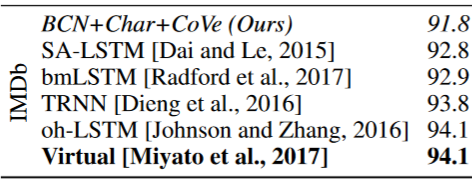

As you see, we just got a new state of the art result in sentiment analysis, decreasing the error from 5.9% to 5.5%! You should be able to get similarly world-class results on other NLP classification problems using the same basic steps.

There are many opportunities to further improve this, although we won't be able to get to them until part 2 of this course...

### End